<a href="https://colab.research.google.com/github/tsutsumi-ozro/NLP100knock/blob/main/NLP100knock_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ

## 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．



In [1]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-04-16 02:37:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  13.3MB/s    in 2.1s    

2022-04-16 02:37:58 (13.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
import gdown
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=True)

# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [5]:
import string
import torch
def transform_x2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split() #記号をスペースに置換して、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]

  return torch.tensor(sum(vec) / len(vec))

In [6]:
#特徴ベクトルの作成
X_train = torch.stack([transform_x2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_x2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_x2v(text) for text in test['TITLE']])
print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [7]:
#ラベルベクトルの作成
category_dict = {'b':0, 't':1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)


torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [8]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

## 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．


In [9]:
#単層のnnを定義
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [10]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.4842, 0.3676, 0.0197, 0.1285]], grad_fn=<SoftmaxBackward0>)


In [11]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.4842, 0.3676, 0.0197, 0.1285],
        [0.1471, 0.0160, 0.6819, 0.1550],
        [0.4006, 0.0706, 0.0243, 0.5045],
        [0.5263, 0.3272, 0.0567, 0.0898]], grad_fn=<SoftmaxBackward0>)


## 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
model(X_train[:1])

tensor([[ 1.7020,  1.4264, -1.4981,  0.3753]], grad_fn=<MmBackward0>)

In [14]:
y_train[:1]

tensor([0])

In [16]:
l_1 = criterion(model(X_train[:1]), y_train[:1])
model.zero_grad() #Optimizer.zero_grad() 最適化されたtorch.tensorをの勾配を０にする
l_1.backward() 
print(f'損失: {l_1:.4f}')
print(f'勾配: \n{model.fc.weight.grad}')

損失: 0.7252
勾配: 
tensor([[-0.0432, -0.0029, -0.0035,  ..., -0.0387, -0.0223,  0.0448],
        [ 0.0308,  0.0021,  0.0025,  ...,  0.0276,  0.0159, -0.0319],
        [ 0.0017,  0.0001,  0.0001,  ...,  0.0015,  0.0009, -0.0017],
        [ 0.0107,  0.0007,  0.0009,  ...,  0.0097,  0.0056, -0.0112]])


In [17]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.1042
勾配:
tensor([[-0.0113,  0.0052, -0.0040,  ..., -0.0195,  0.0101,  0.0169],
        [-0.0025, -0.0022,  0.0276,  ...,  0.0308,  0.0214, -0.0058],
        [ 0.0185, -0.0072, -0.0312,  ..., -0.0145, -0.0166,  0.0034],
        [-0.0046,  0.0043,  0.0076,  ...,  0.0033, -0.0149, -0.0145]])


## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．



In [18]:
from torch.utils.data import Dataset
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

#__hogehoge__のものはclassが呼び出されたときに実行される


In [19]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [21]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4984, loss_valid: 0.3803
epoch: 2, loss_train: 0.3198, loss_valid: 0.3452
epoch: 3, loss_train: 0.2876, loss_valid: 0.3236
epoch: 4, loss_train: 0.2703, loss_valid: 0.3222
epoch: 5, loss_train: 0.2599, loss_valid: 0.3156
epoch: 6, loss_train: 0.2523, loss_valid: 0.3104
epoch: 7, loss_train: 0.2459, loss_valid: 0.3113
epoch: 8, loss_train: 0.2416, loss_valid: 0.3090
epoch: 9, loss_train: 0.2378, loss_valid: 0.3105
epoch: 10, loss_train: 0.2352, loss_valid: 0.3084


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ

In [22]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred==labels).sum().item()
  return correct / total

In [23]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正答率(train): {acc_train:.3f}')
print(f'正答率(test): {acc_test:.3f}')

正答率(train): 0.926
正答率(test): 0.903


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ

In [24]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss/len(loader), correct/total

In [26]:
#モデルの定義
model = SLPNet(300, 4)
#損失関数の定義
criterion = nn.CrossEntropyLoss()
#optimizerの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

#学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  model.train()
  for inputs, labels in dataloader_train:
    #勾配を0で初期化
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  
  #損失と正答率の計算
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

epoch: 1, loss_train: 0.3252, accuracy_train: 0.8870, loss_valid: 0.3593, accuracy_valid: 0.8780
epoch: 2, loss_train: 0.2816, accuracy_train: 0.9053, loss_valid: 0.3301, accuracy_valid: 0.8915
epoch: 3, loss_train: 0.2673, accuracy_train: 0.9109, loss_valid: 0.3218, accuracy_valid: 0.8945
epoch: 4, loss_train: 0.2573, accuracy_train: 0.9139, loss_valid: 0.3225, accuracy_valid: 0.8877
epoch: 5, loss_train: 0.2429, accuracy_train: 0.9206, loss_valid: 0.3126, accuracy_valid: 0.8937
epoch: 6, loss_train: 0.2395, accuracy_train: 0.9201, loss_valid: 0.3129, accuracy_valid: 0.8952
epoch: 7, loss_train: 0.2362, accuracy_train: 0.9196, loss_valid: 0.3154, accuracy_valid: 0.8930
epoch: 8, loss_train: 0.2289, accuracy_train: 0.9238, loss_valid: 0.3093, accuracy_valid: 0.8915
epoch: 9, loss_train: 0.2273, accuracy_train: 0.9245, loss_valid: 0.3138, accuracy_valid: 0.8922
epoch: 10, loss_train: 0.2334, accuracy_train: 0.9205, loss_valid: 0.3209, accuracy_valid: 0.8900
epoch: 11, loss_train: 0.2225

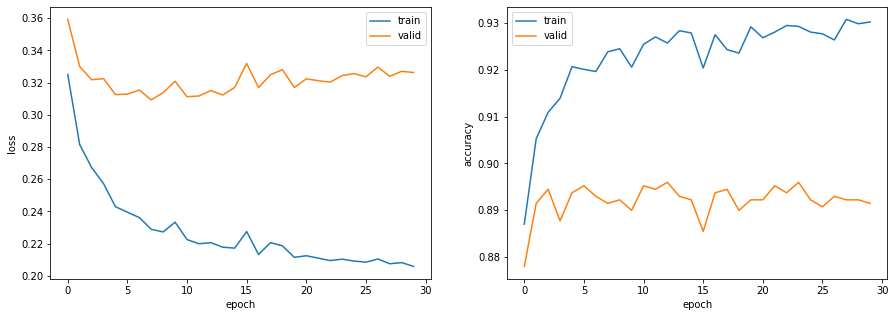

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
# 視覚化
import numpy as np
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [29]:
"""
学習途中のパラメータはmodel.state_dict()、最適化アルゴリズムの内部状態はoptimizer.state_dict()でアクセス可能なので、各エポックでエポック数と合わせて保存する処理を追加します。
"""


# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3277, accuracy_train: 0.8856, loss_valid: 0.3568, accuracy_valid: 0.8705
epoch: 2, loss_train: 0.2862, accuracy_train: 0.8990, loss_valid: 0.3239, accuracy_valid: 0.8877
epoch: 3, loss_train: 0.2704, accuracy_train: 0.9054, loss_valid: 0.3172, accuracy_valid: 0.8915
epoch: 4, loss_train: 0.2566, accuracy_train: 0.9116, loss_valid: 0.3114, accuracy_valid: 0.8922
epoch: 5, loss_train: 0.2439, accuracy_train: 0.9161, loss_valid: 0.3058, accuracy_valid: 0.8885
epoch: 6, loss_train: 0.2375, accuracy_train: 0.9174, loss_valid: 0.3052, accuracy_valid: 0.8870
epoch: 7, loss_train: 0.2348, accuracy_train: 0.9202, loss_valid: 0.3051, accuracy_valid: 0.8885
epoch: 8, loss_train: 0.2308, accuracy_train: 0.9210, loss_valid: 0.3045, accuracy_valid: 0.8922
epoch: 9, loss_train: 0.2302, accuracy_train: 0.9215, loss_valid: 0.3111, accuracy_valid: 0.8937
epoch: 10, loss_train: 0.2256, accuracy_train: 0.9242, loss_valid: 0.3048, accuracy_valid: 0.8915


## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ

In [30]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [31]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3252, accuracy_train: 0.8888, loss_valid: 0.3561, accuracy_valid: 0.8735, 6.4721sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3008, accuracy_train: 0.8940, loss_valid: 0.3412, accuracy_valid: 0.8765, 2.9694sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2878, accuracy_train: 0.9005, loss_valid: 0.3285, accuracy_valid: 0.8847, 1.5920sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2839, accuracy_train: 0.9024, loss_valid: 0.3255, accuracy_valid: 0.8862, 0.8429sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2822, accuracy_train: 0.9032, loss_valid: 0.3242, accuracy_valid: 0.8870, 0.4880sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2814, accuracy_train: 0.9042, loss_valid: 0.3235, accuracy_valid: 0.8907, 0.3019sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2809, accuracy_train: 0.9038, loss_valid: 0.3233, accuracy_valid: 0.8900, 0.2144sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2806, accuracy_train: 0.9039, loss_valid: 0.3232, accuracy_valid: 0.8892, 0.1678sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2808, accuracy_

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ

In [32]:
"""
GPUを指定する引数deviceをcalculate_loss_and_accuracy、train_modelに追加します。
それぞれの関数内で、モデルおよび入力TensorをGPUに送る処理を追加し、deviceにcudaを指定すればGPUを使用することができます。
"""
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [33]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3420, accuracy_train: 0.8821, loss_valid: 0.3653, accuracy_valid: 0.8735, 13.7126sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3036, accuracy_train: 0.8984, loss_valid: 0.3331, accuracy_valid: 0.8937, 7.3517sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2935, accuracy_train: 0.9010, loss_valid: 0.3266, accuracy_valid: 0.8967, 3.4072sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2896, accuracy_train: 0.9018, loss_valid: 0.3242, accuracy_valid: 0.8930, 1.7575sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2874, accuracy_train: 0.9036, loss_valid: 0.3219, accuracy_valid: 0.8975, 0.9812sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2864, accuracy_train: 0.9036, loss_valid: 0.3214, accuracy_valid: 0.8982, 0.5446sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2860, accuracy_train: 0.9039, loss_valid: 0.3210, accuracy_valid: 0.8990, 0.3426sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2855, accuracy_train: 0.9037, loss_valid: 0.3208, accuracy_valid: 0.8990, 0.2295sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2855, accuracy

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [34]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [35]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [37]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 0.8959, accuracy_train: 0.7649, loss_valid: 0.8972, accuracy_valid: 0.7650, 0.5682sec
epoch: 2, loss_train: 0.7066, accuracy_train: 0.7778, loss_valid: 0.7085, accuracy_valid: 0.7829, 0.5315sec
epoch: 3, loss_train: 0.6221, accuracy_train: 0.7862, loss_valid: 0.6251, accuracy_valid: 0.7829, 0.5493sec
epoch: 4, loss_train: 0.5668, accuracy_train: 0.8026, loss_valid: 0.5713, accuracy_valid: 0.7987, 0.5438sec
epoch: 5, loss_train: 0.5260, accuracy_train: 0.8184, loss_valid: 0.5328, accuracy_valid: 0.8091, 0.5341sec
epoch: 6, loss_train: 0.4950, accuracy_train: 0.8313, loss_valid: 0.5031, accuracy_valid: 0.8323, 0.5292sec
epoch: 7, loss_train: 0.4666, accuracy_train: 0.8444, loss_valid: 0.4766, accuracy_valid: 0.8383, 0.5406sec
epoch: 8, loss_train: 0.4456, accuracy_train: 0.8574, loss_valid: 0.4570, accuracy_valid: 0.8496, 0.5547sec
epoch: 9, loss_train: 0.4264, accuracy_train: 0.8642, loss_valid: 0.4390, accuracy_valid: 0.8525, 0.5346sec
epoch: 10, loss_train: 0.409

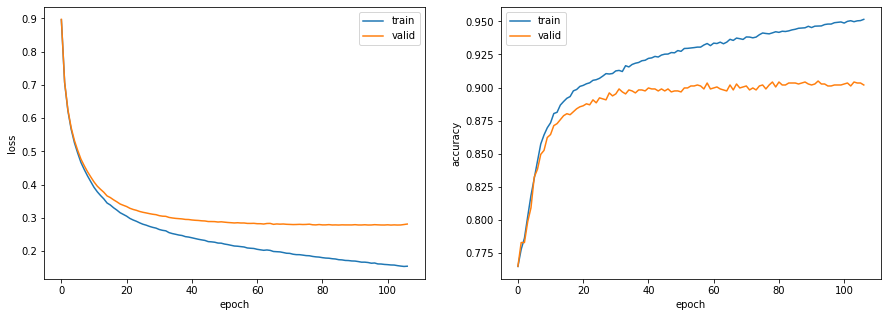

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [39]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [40]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.952
正解率（評価データ）：0.912
